# Training CNN networks



#### Dataset
* [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist)
is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

I am to split the 60,000 images in the predefined training set into a new training set with 50,000 images and a validation set with 10,000 images. Fashion-MNIST is a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training, validation and testing splits.

## Part 1. Writing a custom dataset based on Fashion-MNIST

### Part 1.1. Define a Dataset class
Here we define a custom dataset by extending the [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class.

In [7]:
!pip install onedrivedownloader

In [8]:
from onedrivedownloader import download
import os
link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/msavic21_univ_yo_oulu_fi/EY1hdgh6AvZKvqYn3WFp5XMB1EDaL0IYST9PIPdBB8f0Eg?e=NSxK4b'

if not os.path.exists('./data/fashion_mnist_npy'):
    print('Downloading dataset')
    download(link, filename="./fashion_mnist_npy_hw3", unzip=True, unzip_path='./data/fashion_mnist_npy')

100%|██████████| 30.6M/30.6M [00:02<00:00, 12.9MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 4/4 [00:00<00:00, 17.98it/s]


In [11]:
# import necessary packages
import os
import torch
import requests, zipfile, sys
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms


# fashion_MNIST dataset
data_dir='./data/fashion_mnist_npy/'
train_data = np.load(os.path.join(data_dir, 'train_data.npy'))
test_data = np.load(os.path.join(data_dir, 'test_data.npy'))
train_label = np.load(os.path.join(data_dir, 'train_labels.npy'))
test_label = np.load(os.path.join(data_dir, 'test_labels.npy'))

print(len(train_label))
# split the training data to a new training data and validation data
class_indices = [[] for i in range(10)]
for i, v in enumerate(train_label):
    class_indices[v].append(i)

indices_all = np.random.permutation(len(class_indices[0]))
# take the first 1000 indices of indices_all
indices = indices_all[:1000]
# take the rest of the indices of indices_all
indices_rest = indices_all[1000:]

valid_indices = []
train_indices = []
for i in range(10):
    # build indices for validation set
    valid_indices.extend(np.array(class_indices[i])[indices])
    # build indices for training set
    train_indices.extend(np.array(class_indices[i])[indices_rest])

# write the custom dataset based on the dataset
class FashionMnist(Dataset):
    """Fashion Mnist dataset"""

    def __init__(self, phase='train', transform=None):

        # split the predefined training data
        if 'train' == phase:
            self.data = train_data[train_indices]
            self.labels = train_label[train_indices]


        elif 'valid' == phase:
            self.data = train_data[valid_indices]
            self.labels = train_label[valid_indices]


        elif 'test' == phase:
            self.data = test_data
            self.labels = test_label


        else:
            assert True, 'wrong phase'


        self.transform = transform

        self.label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt','Sneaker','Bag','Ankle boot']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # get image and label according to the index
        img = self.data[index]
        label = self.labels[index]

        # to return a PIL Image
        img = Image.fromarray(img, mode='L')

        if self.transform is not None:
            img = self.transform(img)

        return img, label


60000


### Part 1.2. Dataset checking
First, randomly show some images in training, validation and testing data and check if the images have correct labels.<br>
Secondly, check the number of images for each class, to make sure the dataset created correctly.

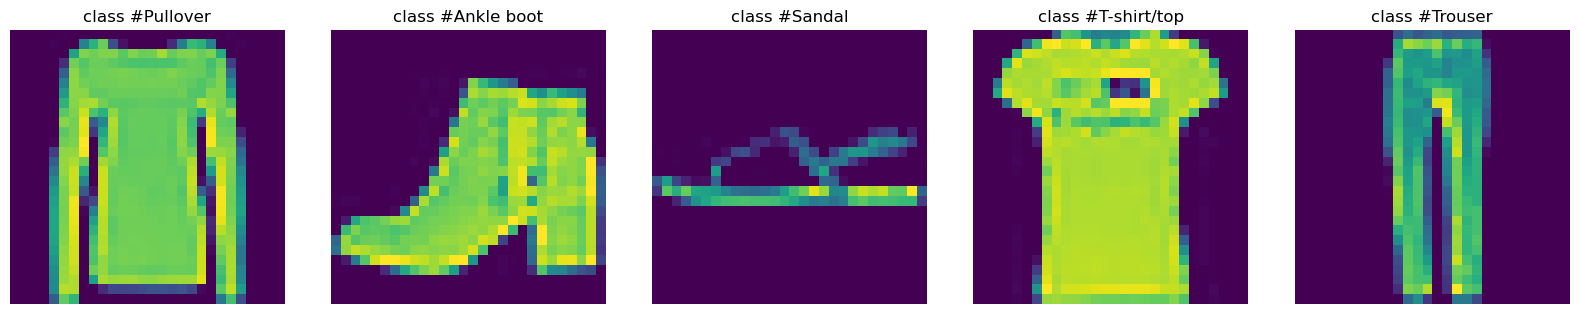

total number of training set: 50000
number of images for class T-shirt/top: 5000
number of images for class Trouser: 5000
number of images for class Pullover: 5000
number of images for class Dress: 5000
number of images for class Coat: 5000
number of images for class Sandal: 5000
number of images for class Shirt: 5000
number of images for class Sneaker: 5000
number of images for class Bag: 5000
number of images for class Ankle boot: 5000


In [14]:
# checking training set
# randomly show some samples and their labels
# create a FashionMnist dataset for training, set transform to None
train_set = FashionMnist(phase = 'train', transform = None)

num_to_show = 5
idx = np.random.choice(range(len(train_set)), num_to_show, replace=False) # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = train_set[idx[i]]
    label_name = train_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of training set: {}'.format(len(train_set)))
for i in range(10):
    print('number of images for class {}: {}'.format(train_set.label_names[i], np.sum(train_set.labels == i)))

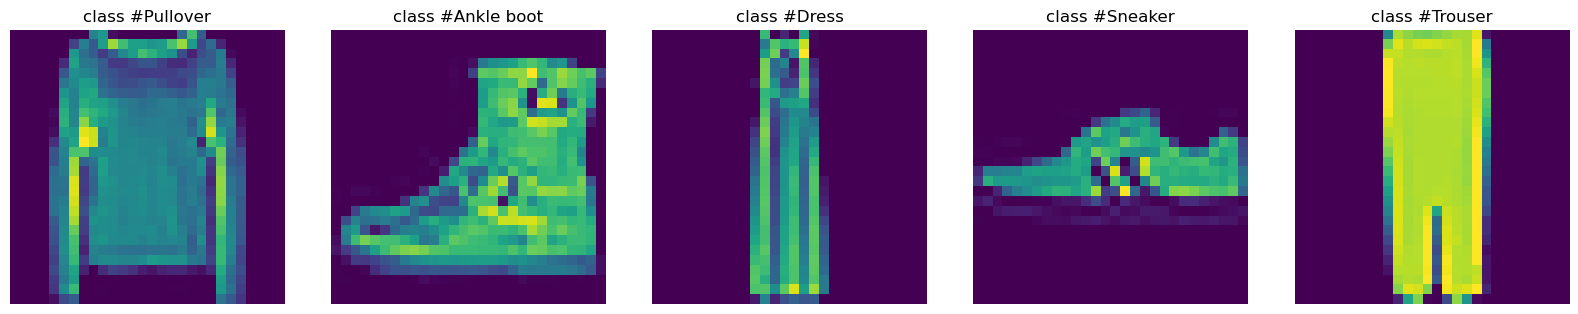

total number of validating set: 10000
number of images for class T-shirt/top: 1000
number of images for class Trouser: 1000
number of images for class Pullover: 1000
number of images for class Dress: 1000
number of images for class Coat: 1000
number of images for class Sandal: 1000
number of images for class Shirt: 1000
number of images for class Sneaker: 1000
number of images for class Bag: 1000
number of images for class Ankle boot: 1000


In [16]:
# checking validation data
# like the training set, the output in this section should be like this
valid_set = FashionMnist(phase='valid', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(valid_set)), num_to_show, replace=False)  # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = valid_set[idx[i]]
    label_name = valid_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of validating set: {}'.format(len(valid_set)))
for i in range(10):
    print('number of images for class {}: {}'.format(valid_set.label_names[i], np.sum(valid_set.labels == i)))


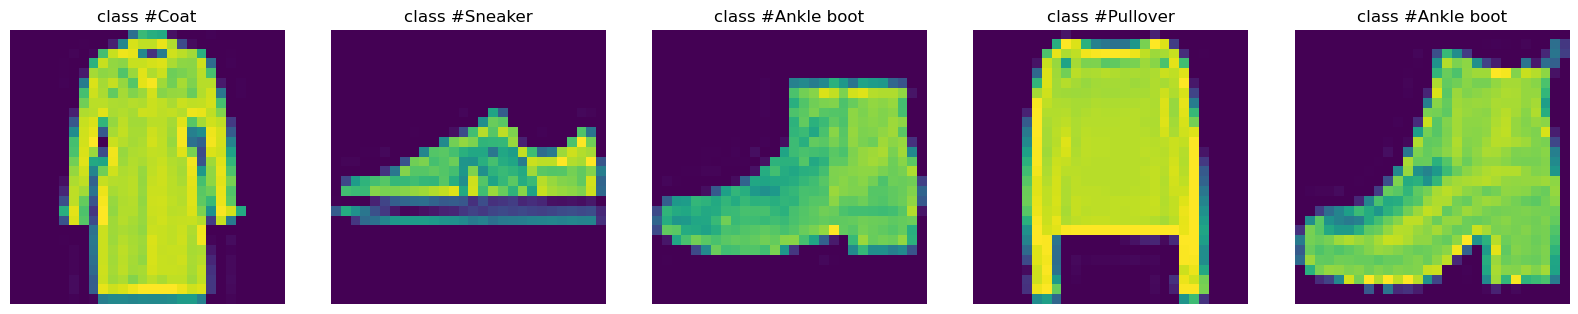

total number of testingset: 10000
number of images for class T-shirt/top: 1000
number of images for class Trouser: 1000
number of images for class Pullover: 1000
number of images for class Dress: 1000
number of images for class Coat: 1000
number of images for class Sandal: 1000
number of images for class Shirt: 1000
number of images for class Sneaker: 1000
number of images for class Bag: 1000
number of images for class Ankle boot: 1000


In [18]:
# checking testing data
test_set = FashionMnist(phase='test', transform=None)

num_to_show = 5
idx = np.random.choice(range(len(test_set)), num_to_show, replace=False)  # randomly pick 5 pictures to show

fig = plt.figure(figsize=(16, 8))

for i in range(len(idx)):
    image, label = test_set[idx[i]]
    label_name = test_set.label_names[label]

    ax = plt.subplot(1, num_to_show, i + 1)
    plt.tight_layout()
    ax.set_title('class #{}'.format(label_name))
    ax.axis('off')
    plt.imshow(np.asarray(image))

plt.show()

# print number of images for each class
print('total number of testingset: {}'.format(len(test_set)))
for i in range(10):
    print('number of images for class {}: {}'.format(test_set.label_names[i], np.sum(test_set.labels == i)))


### Part 1.3. Iterating through the dataset with batches
Here, we add more features with the help of [DataLoader](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#iterating-through-the-dataset):
* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear.

The `DataLoader` takes as input an instance of `FashionMnist` we defined in Part 1.1. Since images in the dataset currently are all in PIL format, I have to convert them to torch.Tensor by using a transform. Actually, `transform` is often used for data augmentation, further illustrations of `transform` can be found in [https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#writing-custom-datasets-dataloaders-and-transforms).

In [22]:
# Set batch_size to 64, shuffling the training set
data_transform = transforms.Compose([transforms.ToTensor()])

train_set = FashionMnist(phase='train', transform=data_transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)

# create test_loader and valid_loader, both with no shuffling
test_set = FashionMnist(phase='test', transform=data_transform)
valid_set = FashionMnist(phase='valid', transform=data_transform)

test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0)

## Part 2. Build a CNN on your own
Structure of the CNN (**Conv**: convolutional layer, **BN**: Batch Normalization layer, **Max_pool**: max pooling layer, **FC**: fully connected layer, batch_size=64):
<!--![model.png](attachment:model.png)-->
<img src=https://raw.githubusercontent.com/marukosan93/DL2024_resources/refs/heads/master/CNN.png width="800">

In [25]:
import torch
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # define layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()

        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
         # forwards pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

## Part 3. Train and test your CNN model

### Part 3.1. Create functions for train and evaluation
* Instantiate a network.
* When training, create an optimizer to take care of network's parameters, calculate the loss and accuracy.
* When evaluating, only the accuracy needs to be calculated

In [29]:
# instantiate a network
net = Network(num_classes=10)

# evaluation function
def eval(net, data_loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# training function
def train(net, train_loader, valid_loader):
    loss_function = torch.nn.CrossEntropyLoss()
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0)

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    epoches = 10
    for epoch in range(epoches):
        net.train()
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()

            # Forward propagation
            outputs = net(images)
            loss = loss_function(outputs, labels)

            # Backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            preds = outputs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            num_images += len(labels)
        acc = correct / num_images
        acc_eval = eval(net, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return net

### Part 3.2. Train and test your network

In [33]:
trained_net = train(net, train_loader, valid_loader)
acc_test = eval(trained_net, test_loader)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

epoch: 0, lr: 0.010000, accuracy: 0.885060, loss: 0.479779, valid accuracy: 0.883000
epoch: 1, lr: 0.010000, accuracy: 0.899740, loss: 0.255455, valid accuracy: 0.893800
epoch: 2, lr: 0.010000, accuracy: 0.910620, loss: 0.190406, valid accuracy: 0.905000
epoch: 3, lr: 0.010000, accuracy: 0.918460, loss: 0.066242, valid accuracy: 0.900800
epoch: 4, lr: 0.010000, accuracy: 0.927480, loss: 0.353252, valid accuracy: 0.907500
epoch: 5, lr: 0.010000, accuracy: 0.934660, loss: 0.146734, valid accuracy: 0.912000
epoch: 6, lr: 0.010000, accuracy: 0.939840, loss: 0.050149, valid accuracy: 0.913600
epoch: 7, lr: 0.010000, accuracy: 0.944660, loss: 0.105410, valid accuracy: 0.912200
epoch: 8, lr: 0.010000, accuracy: 0.950200, loss: 0.196897, valid accuracy: 0.916800
epoch: 9, lr: 0.010000, accuracy: 0.954720, loss: 0.011589, valid accuracy: 0.909400
accuracy on testing data: 0.901700
